## Specify Inputs

In [ ]:
#Define Batches
batches = "UCB005" #for baseline cell utilization plot
batches = "CPD023A[C-Z]|CPD021F|CPD021G" #for Cathy Cell Utilization Plot 

batches = "UCB005B" #Tier 1 Baseline
batches = "CPD021F[C-Z]|CPD021G[A-Z]|CPD023B[A-Z]|UCD011AZ|UCD011B"  #Tier 1 Development
#batches = "CPD021F[C-Z]|CPD021G[A-Z]|CPD023B[A-Z]|UCD011AZ|UCD011B|UCB005B"  #Tier 2


# Define Unit Cells in ML
Layers = 3 # Number of unit cells in each MultiSlayer pouch

# Specify any defective/cracked cells to flag and remove from pairing
DefectiveCells = ['UCB005AC-US00-29', 'UCB005AC-US01-14', 'UCB005AC-US02-08', 
                  'UCB005AD-US00-32', 'UCB004AD-US00-55', 'UCB005AD-US01-20', 'UCB005AD-US01-08',
                  'UCB005AH-US00-38', 'UCB005AH-US00-14', 'UCB005AH-US01-06',
                  'UCB005AJ-US01-20',
                  'UCB005AN-US01-02', 'UCB005AN-US01-06',
                  'UCB005AP-US00-08',
                  'UCB005AQ-US00-05',
                  'UCB005AR-US00-36','UCB005AR-US00-08',
                  'UCB005AU-US00-11',
                  'UCB005BA-US00-05', 'UCB005BA-US00-08',
                  'UCB005BE-US00-25', 'UCB005BE-US00-12',
                  'UCD011AP-US02-05', 'UCD011AR-US00-21', 'UCD011AV-US00-09', 'UCD011AX-US00-13',
                  'UCD014AA-US00-01',
                  'UCD015AC-US01-29',
                  'CPD021FC-US00-12',
                  'CPD023AD-US00-15', 'CPD023AE-US00-12', 'CPD023AL-US00-17', 'CPD023AM-US01-12', 'CPD023AQ-US01-11', 'CPD023AQ-US00-19', 'CPD023AR-US01-01', 'CPD023AX-US00-08', 'CPD023AX-US01-03', 'CPD023AZ-US02-04',
                  'CPD023BA-US00-08',
                  ]


#Specify any missing cells to flag and remove from pairing
MissingCells = ["UCB004AH-US00-18", "UCB004AH-US00-61", 
                 "UCB005AB-US01-02", "UCB005AC-US00-46", "UCB005AG-US01-17", "UCB005AH-US01-24", "UCB005AP-US00-04", "UCB005AS-US00-08", "UCB005AW-US00-31",'UCB005AY-US00-02', "UCB005AZ-US00-23", 
                 "UCB005AM-US00-11", "UCD015AJ-US00-12", "UCD011AR-US00-03", "UCD015AC-US01-07", "UCD014AA-US00-20", "UCD011AP-US00-16",
                 "UCB005BD-US00-11", "UCB005BD-US00-25", "UCB005BD-US00-31", "UCB005BD-US00-30", "UCB005BD-US00-32",
                 "CPD021FC-US00-18", "CPD021FD-US00-07", "CPD021FD-US00-16",
                 "CPD023AR-US01-08", "CPD023AS-US01-13", "CPD023AQ-US01-13", "CPD023AQ-US00-19", "CPD023AW-US00-04", "CPD023AX-US00-12", "CPD023AX-US00-19", "CPD023AY-US00-05", "CPD023AY-US00-12", "CPD023AY-US00-16", 
                 "UCB005BA-US00-02", "UCB005BC-US00-35", "UCB005BD-US00-09", "UCB005BD-US00-37", "UCB005BE-US00-01", "UCB005BE-US00-21", "UCB005BE-US00-34", "UCB005BG-US00-11", "UCB005BG-US00-41"] #these cells have an edge case in alignment and will need to be paired seperately



#Tier and pair specific cells (CustomList) instead of batches
UseCustomList = 0 #needs to be 1 to only Tier and Pair the listed cells below
#This is the list of specific cells you want to Tier and Pair
CustomList = ['UCD011AX-US00-13', 'UCD015AG-US00-22', 'UCD011AV-US00-09', 'UCD014AD-US00-25', 'CPD021EA-US00-06', 'CPD023AU-US00-04', 'UCB005BD-US00-09', 'UCD011AV-US00-16']




#Cell Status Settings
ShowOnlyYield = 1 #Only Group/Pair cells that yielded according to datahub, change this variable to pair "non-yielded" cells as well 
GroupWaitingOnly = 1 #Only Group/Pair cells that have a cell status of "Waiting", needs to be 1 to only pair "Waiting" cells 
#Grouping Criteria
ASR_range_limit = 2.0   #threshold for ASR range in ML (usually 2.0)
ASR_mean_min_limit= 0.5 # threshold for ASR mean-min in ML (usually 0.5)
max_attempts = 10   # how many times the pairing loop will run before giving up. It will reorder the remaining cells by ASR instead of Rank after max_attempts/2, increase this number if you still see possible groups in the "Remainder" cells

## Import Modules and Functions

In [1044]:
#import modules used in this script
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from qsdc.client import Client
#import functions used in this script
import query_tray_samples_V4 as query_tray_samples
#assert version("qs-data-client") >= "0.2.15", "qsdc version must be greater than 0.2.15"

#Remove warning messages
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
#establish clients 
qs_client = Client()
conn = qs_client.get_mysql_engine()

# !pip install --upgrade qs-data-client  ## RUN THIS IF YOU NEED TO UPDATE qs-data-client
#Run in terminal if not already logged in:     gcloud auth application-default login

## Pull Cell Data From Datahub

In [1045]:
## Query Data from Datahub

#Pull cell metrology data from datahub, both standard/auto metrology and manual review
dfctq = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UC-CTQ') ## standard metro review of unit cells
dfmr = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UC-MR') ## manual review of unit cells

#Pull geneology/multilayer info
dmlg = qs_client.data_hub.get_dataset(dataset = 'MFG-80L-ML-PRODUCTION') ##multilayer info (ML_id)
dmlg = dmlg.dropna(subset="US_id").drop_duplicates()
#dgen = qs_client.data_hub.get_dataset(dataset = 'MFG-MASTER-GENEALOGY') ##multilayer info (ML_id)
danc = qs_client.data_hub.get_dataset("MFG-UNIT-CELL-ANCESTRY")

#Pull Cathode Mass data
cathode_mass = qs_client.data_hub.get_dataset("MFG-50L-CATHODE-CTQ")
cathode_mass = cathode_mass[["PU_id", "cathode_dry_mass"]]
danc = danc[["US_id","PU_id"]].dropna(subset="US_id").drop_duplicates()
danc = danc.merge(cathode_mass, on = "PU_id", how = "left").sort_values(["US_id"])
danc = danc.rename(columns={'US_id': 'US_ID'}) 




#Pull cell electrical test data
dfc = qs_client.data_hub.get_dataset(dataset = 'MFG-60L-UNIT-CELL-TEST-CYCLE') ##electrical test data of unit cells
cols = [
    "US_id",
    "TestCycleStart_datetime_first",
    "TestCycleStart_datetime",
    "UCT_Version",
    "idtest_recipe",
    "RunIndex",
    "CycleIndex",
    "dvdt",
    "recipe_dvdt_range",
    "CeilingHoldTime",
    "CE",
    "CapacityChargeFraction",
    "CeilingRestVoltage",
    "AMSDcCapacity",
    "CycleFailure",
    "AnyFailure",
    "MedDcASR",
    "DischargeCapacity"
]

#Filter datahub rows by batches 
if UseCustomList != 1:
    # Keep cells from batches of interest and remove those that failed screening
    filtered_dfctq = dfctq[dfctq['US_id'].str.contains(batches, na=False)] #keep cells that are from the batches of interest
    filtered_dfmr = dfmr[dfmr['US_id'].str.contains(batches, na=False)] #keep only cells that are from the batches of interest
    dfc = dfc[dfc['US_id'].str.contains(batches, na=False)].sort_values(["RunIndex","CycleIndex"])[cols]
    if ShowOnlyYield == 1:
        yielded_dfctq = filtered_dfctq[filtered_dfctq['unit_cell_test_yield'] == 1] #keep cells that yielded
        yielded_dfmr = filtered_dfmr[filtered_dfmr['unit_cell_test_yield'] == 1] #keep cells that yielded
        
#Filter datahub rows by custom list
if UseCustomList == 1:
    yielded_dfctq = dfctq[dfctq['US_id'].isin(CustomList)]
    yielded_dfmr = dfmr[dfmr['US_id'].isin(CustomList)]
    #dfc = dfc[dfc['US_id'].isin(CustomList)][cols]
    batches = "CustomList"
    

KeyboardInterrupt: 

## Generate Cell Status/Tier Spreadsheet

### Combine Automated and Manual Review Data into one dataframe

In [ ]:
## Overwrite automated results with manual review results
# First, merge the DataFrames on 'US_id' to align rows
merged_df = yielded_dfctq.merge(yielded_dfmr[['US_id', 'edge_thickness_tier_us_mr', 'A1_anode_tier_top_us_mr', 'A1_anode_tier_bottom_us_mr',
                                              'cathode_alignment_custom_model_tier_us_mr', 'median_contour_catholyte_pct_us_mr', 'max_f2f_distance_us','disposition_mr', 'failure_modes_mr']], on='US_id', how='left')
# Then, overwrite 'edge_thickness_tier_us' in 'filtered_dfctq' where 'edge_thickness_tier_us_mr' has a value
merged_df['edge_thickness_tier_us'] = merged_df['edge_thickness_tier_us_mr'].combine_first(merged_df['edge_thickness_tier_us'])
# Then, overwrite 'A1_anode_tier_top_us' in 'filtered_dfctq' where 'A1_anode_tier_top_us_mr' has a value
merged_df['A1_anode_tier_top_us'] = merged_df['A1_anode_tier_top_us_mr'].combine_first(merged_df['A1_anode_tier_top_us'])
# Then, overwrite 'A1_anode_tier_bottom_us' in 'filtered_dfctq' where 'A1_anode_tier_bottom_us_mr' has a value
merged_df['A1_anode_tier_bottom_us'] = merged_df['A1_anode_tier_bottom_us_mr'].combine_first(merged_df['A1_anode_tier_bottom_us'])
# Then, overwrite 'A1_anode_tier_bottom_us' in 'filtered_dfctq' where 'A1_anode_tier_bottom_us_mr' has a value
merged_df['cathode_alignment_custom_model_tier_us'] = merged_df['cathode_alignment_custom_model_tier_us_mr'].combine_first(merged_df['cathode_alignment_custom_model_tier_us'])
#merged_df.loc[merged_df['cathode_alignment_custom_model_tier_us_mr'].notna(), 'cathode_alignment_custom_model_tier_us'] = \
    #merged_df['cathode_alignment_custom_model_tier_us_mr']

# Then, overwrite 'A1_anode_tier_bottom_us' in 'filtered_dfctq' where 'A1_anode_tier_bottom_us_mr' has a value
merged_df['median_contour_catholyte_pct_us'] = merged_df['median_contour_catholyte_pct_us_mr'].combine_first(merged_df['median_contour_catholyte_pct_us'])
# Then, overwrite 'disposition_us' in 'disposition_mr' has a value
merged_df['disposition'] = merged_df['disposition_mr'].combine_first(merged_df['disposition'])
# Then, overwrite 'disposition_us' in 'disposition_mr' has a value
merged_df['failure_modes'] = merged_df['failure_modes_mr'].combine_first(merged_df['failure_modes'])
# Drop the 'edge_thickness_tier_us_mr' column if you don't need it
dfctq_updated = merged_df.drop(columns=['edge_thickness_tier_us_mr', 'A1_anode_tier_top_us_mr', 'A1_anode_tier_bottom_us_mr',
                                              'cathode_alignment_custom_model_tier_us_mr', 'median_contour_catholyte_pct_us_mr', 'disposition_mr','failure_modes_mr' ])


#Update Final Tier of Cells
conditions = [
    dfctq_updated['disposition'] == 'Tier 1',
    dfctq_updated['disposition'] == 'Tier 2',
    dfctq_updated['disposition'] == 'Fail',
    dfctq_updated['disposition'] == 'Scrap',
    dfctq_updated['disposition'] == 'Missing Data',
]
choices = ['1', '2', '3','Scrapped', 'TBD']
dfctq_updated['Tier'] = np.select(conditions, choices)

### Assign Tiering Metrics, Cell Status, Electrical Metrics, and Tray Location

In [ ]:
## Fill in tiering metrics based on data pulled from datahub

## Rename Spreadsheet and sample/batch columns
CellTiering = dfctq_updated[['US_id']].rename(columns={'US_id': 'Cell ID'}) 
CellTiering['Batch'] = dfctq_updated['US_process_flow'] #Create Tiering Spreadsheet
# Create columns for final spreadsheet
new_columns = ["Cell Status", "Cell Tier", "Edge Wetting", "Thickness", "Alignment", "Anode","Film-to-Film Distance", "Cathode Mass"]
for col in new_columns:
    CellTiering[col] = np.nan


##Update Cell Tiering metrics in final spreadsheet
# Merge the dfctq_updated with the CellTiering
merged_df = CellTiering.merge(
    dfctq_updated[['US_id', 'Tier', 'median_contour_catholyte_pct_us', 'edge_thickness_tier_us', 'center_normalized_0_5mm_eroded_rect_outside_median_us', 
                   'cathode_alignment_custom_model_tier_us', 'A1_anode_tier_top_us','A1_anode_tier_bottom_us', 'max_f2f_distance_us']],
    left_on='Cell ID',
    right_on='US_id',
    how='left'
)
# Update final 'Cell Tier' columns with data from dfctq_updated
merged_df['Cell Tier'] = merged_df['Tier']
#Update 'Edge Wetting' column
EWconditions = [
    merged_df['median_contour_catholyte_pct_us'] < 80,
    (merged_df['median_contour_catholyte_pct_us'] >= 80) & (merged_df['median_contour_catholyte_pct_us'] <= 98),
    merged_df['median_contour_catholyte_pct_us'] > 98
]
EWchoices = [3, 2, 1]
merged_df['Edge Wetting'] = np.select(EWconditions, EWchoices)
#Update 'Thickness' Column
merged_df['Thickness'] = merged_df['edge_thickness_tier_us']
#Update Alignment' Column
merged_df['Alignment'] = merged_df['cathode_alignment_custom_model_tier_us']
#Update 'Anode' Column
merged_df['Anode'] = np.maximum(merged_df['A1_anode_tier_top_us'], merged_df['A1_anode_tier_bottom_us'])
#Update 'Film-to-Film Distance Column
merged_df.loc[merged_df['max_f2f_distance_us'] > 0.40, 'Film-to-Film Distance'] = 'High' #merged_df['Film-to-Film Distance'] = 'Low'  # Default value
#Update the 'Cathode Mass' Column
merged_df = merged_df.merge(danc[['US_ID', 'cathode_dry_mass']], left_on='Cell ID', right_on='US_ID', how='left')
merged_df['Cathode Mass'] = merged_df['cathode_dry_mass']

# Drop the extra columns from dfctq_updated
CellTiering = merged_df.drop(columns=['US_id', 'Tier', 'edge_thickness_tier_us','cathode_alignment_custom_model_tier_us',
                                      'A1_anode_tier_top_us','A1_anode_tier_bottom_us','max_f2f_distance_us', 'US_ID', 'cathode_dry_mass'])



## Asign Final Tier to every cell
# Select columns that we are considering for tiering
columns_to_consider = ['Alignment', 'Anode', 'Thickness', 'Edge Wetting']
CellTiering['Alignment'] = CellTiering['Alignment'].fillna(0)  # Replace NaN with 0 (or another placeholder)
CellTiering['Alignment'] = CellTiering['Alignment'].astype(int) #convert to integer
CellTiering['Anode'] = CellTiering['Anode'].fillna(0)  # Replace NaN with 0 (or another placeholder)
CellTiering['Anode'] = CellTiering['Anode'].astype(int) #convert to integer
CellTiering['Thickness'] = CellTiering['Thickness'].fillna(0)  # Replace NaN with 0 (or another placeholder)
CellTiering['Thickness'] = CellTiering['Thickness'].astype(int) #convert to integer
CellTiering['Edge Wetting'] = CellTiering['Edge Wetting'].fillna(0)
CellTiering['Edge Wetting'] = CellTiering['Edge Wetting'].astype(int) #convert to integer
#Fill out Cell Tier
CellTiering['Cell Tier'] = CellTiering[columns_to_consider].max(axis=1) #Update cell tier based on avaialable tiering metrics
missing_or_zero = (CellTiering[columns_to_consider].isnull() | (CellTiering[columns_to_consider] == 0)).any(axis=1) #Identify cells that are missing data
CellTiering.loc[missing_or_zero, 'Cell Tier'] = 0 # Update 'Cell Status' for these rows


##Update 'Cell Status' if yielded cell is on already in a multilayer pouch, has high F2F Misalignment, or is Cracked/Scrapped
# Merge 'CellTiering' with 'dmlg' to align 'Cell ID' and 'US_id'
merged_df = CellTiering.merge(dmlg[['US_id', 'ML_id']], left_on='Cell ID', right_on='US_id', how='left')

# Update 'Cell Status' with 'ML_id' where a match exists
CellTiering['Cell Status'] = np.where(
    merged_df['ML_id'].notnull(),  # Check if 'ML_id' is not null
    merged_df['ML_id'],  # Use 'ML_id' value
    CellTiering['Cell Status']  # Otherwise, keep the original 'Cell Status'
)

#Update Cell if it has high F2F Misalignment
CellTiering.loc[CellTiering['Film-to-Film Distance'] == 'High', 'Cell Status'] = 'High F2F Misalignment' 
#Update Cell if it is cracked
CellTiering.loc[CellTiering['Cell ID'].isin(DefectiveCells), 'Cell Status'] = 'Damaged/Scrapped'
#Update Cell if it is missing
CellTiering.loc[CellTiering['Cell ID'].isin(MissingCells), 'Cell Status'] = 'Missing/Lost'
# Identify rows where any of the specified columns are missing or contain 0
columns_to_check = ['Edge Wetting', 'Thickness', 'Alignment', 'Anode']
missing_or_zero = (CellTiering[columns_to_check].isnull() | (CellTiering[columns_to_check] == 0)).any(axis=1)
CellTiering.loc[missing_or_zero, 'Cell Status'] = 'Missing Tiering Metrics' # Update 'Cell Status' for these rows
#Fill in default status of 'Waiting'
CellTiering['Cell Status'] = CellTiering['Cell Status'].fillna('Waiting')



## Update cell electrical metrics
def last_non_missing(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else None
# Group by 'US_id' and aggregate using the last non-missing values
dfc_consolidated = (
    dfc.groupby('US_id', as_index=False)
    .agg({
        'MedDcASR': last_non_missing,
        'DischargeCapacity': last_non_missing
    })
)
dfc_consolidated = dfc_consolidated.rename(columns={'US_id': 'Cell ID','MedDcASR': 'MedDischargeASR_1C', 'DischargeCapacity': 'DischargeCapacity_Co3'})# Consolidate column renaming in a single step
CellTiering = pd.merge(CellTiering, dfc_consolidated, left_on='Cell ID', right_on='Cell ID', how='left')


## Update tray location ##
sample_names_group = CellTiering["Cell ID"]
df_tray = query_tray_samples.get_sample_tray(sample_names_group)
CellTiering = pd.merge(CellTiering, df_tray[['sample_name', 'tray_id', 'row_index', 'col_index', 'modified']], left_on='Cell ID', right_on='sample_name', how='left')
CellTiering = CellTiering.drop(columns=['sample_name', 'modified'])


### Save spreadsheet showing 'Cell Status' and 'Tier' for all cells in the batches

In [ ]:
##save Tiering spreadsheet
current_date = datetime.now().strftime('%Y-%m-%d')
if "|" in batches:
    batches = batches.replace("|", "_")
output_name = f'{current_date}_{batches}_Tier.xlsx'
CellTiers = CellTiering.copy()
#CellTiers = CellTiers.drop(columns=['median_contour_catholyte_pct_us', 'center_normalized_0_5mm_eroded_rect_outside_median_us']) #drop rows that we don't need to show in the spreadsheet
CellTiers = CellTiers.rename(columns={'median_contour_catholyte_pct_us': 'Edge Wetting Pct','center_normalized_0_5mm_eroded_rect_outside_median_us': 'Normalized Thickness', 'Film-to-Film Distance':'F2F Distance'})
CellTiers['Cell Tier'] = pd.to_numeric(CellTiers['Cell Tier'], errors='coerce')
CellTiers = CellTiers.sort_values(by=['Cell Tier', 'MedDischargeASR_1C'], ascending=[True, True])
CellTiers.to_excel(output_name, index=False)


## Group Eligible Cells

### Filter cells that are eligible for grouping

In [ ]:
## Format and prepare dataframes for TOPSIS Rank and Grouping

#Rename 
TieredCells = CellTiering

#Keep Cells that have not been grouped
if GroupWaitingOnly == 1:
    TieredCells = TieredCells[TieredCells["Cell Status"] == "Waiting"]

#Keep Tier 1 Cells to commence pairing of Tier 1 groups
TieredOneCells = TieredCells[TieredCells['Cell Tier'] == 1].copy()
TieredTwoCells = TieredCells[TieredCells['Cell Tier'] == 2].copy()
TieredThreeCells = TieredCells[TieredCells['Cell Tier'] == 3].copy()

# Remove duplicate rows across all columns
TieredOneCells = TieredOneCells.drop_duplicates()
TieredTwoCells = TieredTwoCells.drop_duplicates()
TieredThreeCells = TieredThreeCells.drop_duplicates()

### Tier 1: Calculate Cell Score and Ranking using TOPSIS Model

In [ ]:
##Calculate Cell Score and Ranking for Tier 1 Cells using TOPSIS method
# Define the criteria and their corresponding optimization directions
criteria = ['median_contour_catholyte_pct_us', 'center_normalized_0_5mm_eroded_rect_outside_median_us', 'MedDischargeASR_1C', 'DischargeCapacity_Co3', 'Cathode Mass'] 
weights = [0.15, 0.23, 0.30, 0.20, 0.12]  # Equal weights (adjust if needed)
optimization_directions = ['High', 'Proximity', 'Low', 'High', 'Low']  # 'Proximity' for 'Thickness'
target_criteria = ['center_normalized_0_5mm_eroded_rect_outside_median_us']  # Criteria optimized for proximity
targets = [1.0]  # Target value for 'Thickness'


def topsis_with_target_Tier(df, criteria, weights, optimization_directions, target_criteria=None, targets=None):
    
    # Ensure numeric data for criteria
    df[criteria] = df[criteria].apply(pd.to_numeric, errors='coerce')

    normalized_matrix = df[criteria].copy()
    
    # Step 1: Normalize the Decision Matrix
    for col in criteria:
        if target_criteria and col in target_criteria:
            # Calculate absolute deviation from target
            target = targets[target_criteria.index(col)]
            normalized_matrix[col] = np.abs(df[col] - target)  # Deviation
        else:
            # Standard normalization
            normalized_matrix[col] = normalized_matrix[col] / np.sqrt((normalized_matrix[col]**2).sum())
    
    # Step 2: Weight the Criteria
    weighted_matrix = normalized_matrix * weights
    
    # Step 3: Identify Ideal and Negative Ideal Solutions
    ideal_solution = []
    negative_ideal_solution = []
    for col, direction in zip(criteria, optimization_directions):
        if target_criteria and col in target_criteria:
            # For deviation-based criteria, minimize the deviation
            ideal_solution.append(weighted_matrix[col].min())
            negative_ideal_solution.append(weighted_matrix[col].max())
        else:
            if direction == 'High':
                ideal_solution.append(weighted_matrix[col].max())
                negative_ideal_solution.append(weighted_matrix[col].min())
            elif direction == 'Low':
                ideal_solution.append(weighted_matrix[col].min())
                negative_ideal_solution.append(weighted_matrix[col].max())
    
    ideal_solution = np.array(ideal_solution)
    ideal_solution = np.array([
        weighted_matrix.iloc[:, idx].max() if direction == "maximize" else weighted_matrix.iloc[:, idx].min()
        for idx, direction in enumerate(optimization_directions)
    ])

    negative_ideal_solution = np.array(negative_ideal_solution)
    negative_ideal_solution = np.array([
        weighted_matrix.iloc[:, idx].min() if direction == "maximize" else weighted_matrix.iloc[:, idx].max()
        for idx, direction in enumerate(optimization_directions)
    ])
    
    # Step 4: Calculate Distances
    distances_to_ideal = np.sqrt(((weighted_matrix - ideal_solution)**2).sum(axis=1))
    distances_to_negative = np.sqrt(((weighted_matrix - negative_ideal_solution)**2).sum(axis=1))
    
    # Step 5: Calculate TOPSIS Score
    topsis_score = distances_to_negative / (distances_to_ideal + distances_to_negative)
    return topsis_score

# Calculate TOPSIS scores
TieredOneCells['total_rank_score'] = topsis_with_target_Tier(TieredOneCells, criteria, weights, optimization_directions, target_criteria, targets)
# Rank alternatives by TOPSIS score (higher score is better)
TieredOneCells['Rank'] = TieredOneCells['total_rank_score'].rank(ascending=False)
# Arrange Cells by best ranking at the top
TieredOneCells.sort_values(by='Rank', ascending=True, inplace=True)


### Tier 1: Group Cells using ASR Criteria

In [ ]:
df = TieredOneCells
df = df.reset_index(drop=True)
df['Rank'] = (df.index + 1).astype(int)  # Add 1-based rank as integers
remainder = df.copy()  # Start with a copy of the input DataFrame

n = Layers

#Initialize variable and dataframe 
groupnumber = 1  # Initialize group number
df_final = pd.DataFrame()  # Initialize an empty DataFrame for the final result
grouped_list = [] # List to collect all the groups for final concatenation 
attempts = 0

# Keep track of processed indices
processed_indices = set()

while max_attempts > attempts:
    cellstart = 0
    attempts = attempts+1

    if attempts > max_attempts/2:
        remainder = remainder.sort_values(by='MedDischargeASR_1C', ascending=True).reset_index(drop=True)
    
    while len(remainder) >= n + cellstart:
        # Find the next candidate group by slicing remainder
        candidate_group = remainder.iloc[cellstart:cellstart+n].copy()
        print(f"Processing group starting at rank {candidate_group['Rank'].tolist()}: {candidate_group['Cell ID'].tolist()}")

        # Calculate criteria for the group
        asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
        asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()

        print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")

        # Check if group satisfies criteria and replace cells if necessary
        if asr_range >= ASR_range_limit:
            # Replace the highest ASR cell
            max_idx = candidate_group['MedDischargeASR_1C'].idxmax()
            problem_cell_id = candidate_group.loc[max_idx, 'Cell ID']
            print(f"ASR range is too high at {asr_range}, replacing problem cell: {problem_cell_id}")
            # Replace the highest ASR cell here (you can replace it based on your logic)
            i_range = 0

            while asr_range >=ASR_range_limit:
                if n + i_range >= len(remainder):  # Check if the index is valid
                    print(f"No more rows in remainder to replace {problem_cell_id}.")
                    cellstart = cellstart +1
                    break
                candidate_group.loc[max_idx] = remainder.iloc[n + i_range] # Replace the highest ASR cell
                replacement_cell_id = remainder.iloc[n + i_range]['Cell ID']  # Cell ID of the replacement cell
                print(f"Replacing {problem_cell_id} with {replacement_cell_id}")

                # Check for duplicates in 'Cell ID' within the candidate group
                duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                while duplicate_count > 0:
                    print(f"Found {duplicate_count} duplicate(s) of 'Cell ID' in candidate_group. Incrementing i_range.")
                    i_range += 1  # Increment if there are duplicates
                    if n + i_range < len(remainder):
                        candidate_group.loc[max_idx] = remainder.iloc[n + i_range]
                        replacement_cell_id = remainder.iloc[n + i_range]['Cell ID']  # Replacement cell ID
                        print(f"Replacing {problem_cell_id} with {replacement_cell_id}")
                        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                    else:
                        cellstart = cellstart +1
                        break
                asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
                asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()
                print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")
                i_range = i_range+1

        if asr_mean_min >= ASR_mean_min_limit:
            # Replace the lowest ASR cell
            min_idx = candidate_group['MedDischargeASR_1C'].idxmin()
            problem_cell_id = candidate_group.loc[min_idx, 'Cell ID']
            print(f"Minimum ASR is too low at difference of {asr_mean_min}, replacing problem cell: {problem_cell_id}")
            # Replace the lowest ASR cell here (you can replace it based on your logic)
            i_mean_min = 0

            while asr_mean_min >= ASR_mean_min_limit:
                if n + i_mean_min >= len(remainder):  # Check if the index is valid
                    print(f"No more rows in remainder to replace {problem_cell_id}.")
                    cellstart = cellstart +1
                    break
                candidate_group.loc[min_idx] = remainder.iloc[n + i_mean_min]
                replacement_cell_id = remainder.iloc[n + i_mean_min]['Cell ID']  # Replacement cell ID
                print(f"Replacing {problem_cell_id} with {replacement_cell_id}")

                # Check for duplicates in 'Cell ID' within the candidate group
                duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                while duplicate_count > 0:
                    print(f"Found {duplicate_count} duplicate(s) of 'Cell ID' in candidate_group. Incrementing i_mean_min.")
                    i_mean_min += 1  # Increment if there are duplicates
                    if n + i_mean_min < len(remainder):
                        candidate_group.loc[min_idx] = remainder.iloc[n + i_mean_min]
                        replacement_cell_id = remainder.iloc[n + i_mean_min]['Cell ID']  # Replacement cell ID
                        print(f"Replacing {problem_cell_id} with {replacement_cell_id}")
                        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                    else:
                        cellstart = cellstart +1
                        break
                
                asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
                asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()
                print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")
                i_mean_min = i_mean_min+1

        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()

        if asr_range < ASR_range_limit and asr_mean_min < ASR_mean_min_limit and duplicate_count == 0:
            print(f"Established group starting at rank {candidate_group['Rank'].tolist()}: {candidate_group['Cell ID'].tolist()}")
            # Assign the group number
            candidate_group['Group Number'] = groupnumber
            # Add the rows to the final list
            grouped_list.append(candidate_group)
            # Drop rows in "remainder" where "Cell ID" matches any in "candidate_group"
            remainder = remainder[~remainder['Cell ID'].isin(candidate_group['Cell ID'])]
            # Update processed indices
            processed_indices.update(candidate_group.index)
            # Update group number for the next group
            groupnumber += 1
            # Print status
            print(f"Rows in remainder after processing: {len(remainder)}")

# After loop, concatenate all the groups into a single DataFrame
# Check if grouped_list contains valid DataFrames
if not grouped_list:
    print("No valid groups were formed. Creating an empty DataFrame.")
    df_final = pd.DataFrame()  # Handle case where no groups are created
else:
    df_final = pd.concat(grouped_list, ignore_index=True)
    # Calculate the average Rank for each Group Number
    group_avg_rank = df_final.groupby('Group Number')['Rank'].mean().reset_index()
    # Merge the average Rank back into the original DataFrame
    df_final = df_final.merge(group_avg_rank, on='Group Number', suffixes=('', '_avg'))
    # Sort by the average Rank and then by the original Rank for ties
    df_final = df_final.sort_values(by=['Rank_avg', 'Rank'], ascending=True).reset_index(drop=True)
    # Assign new Group Numbers based on the sorted order
    group_number_mapping = {old: new for new, old in enumerate(df_final['Group Number'].unique(), start=1)}
    df_final['Group Number'] = df_final['Group Number'].map(group_number_mapping)
    # Drop the temporary average column if not needed
    df_final = df_final.drop(columns=['Rank_avg'])
    
# Add 'Remainder' label to remaining rows, if applicable
if not remainder.empty:
    remainder['Group Number'] = 'Remainder'
    df_final = pd.concat([df_final, remainder], ignore_index=True)


if not df_final.empty:
    # Reset the index
    df_final = df_final.reset_index(drop=True)    
    # Drop unnecessary columns
    #columns_to_drop = ['median_contour_catholyte_pct_us', 'center_normalized_0_5mm_eroded_rect_outside_median_us', 'total_rank_score']
    columns_to_drop = ['total_rank_score', 'Rank']
    df_final = df_final.drop(columns=columns_to_drop, errors='ignore')  # Use 'errors="ignore"' to avoid errors if columns are missing
    #Rename some columns
    df_final = df_final.rename(columns={'median_contour_catholyte_pct_us': 'Edge Wetting Pct','center_normalized_0_5mm_eroded_rect_outside_median_us': 'Normalized Thickness', 'Film-to-Film Distance':'F2F Distance'})
    # Move 'Group Number' to the first column
    df_final = df_final[['Group Number'] + [col for col in df_final.columns if col != 'Group Number']]



# Print the final DataFrame
print(f"Final Tier 1 DataFrame has {df_final.shape[0]} rows.")

# Save the ranked cells to an Excel file
current_date = datetime.now().strftime('%Y-%m-%d')
output_name = f'{current_date}_{batches}_Tier_1_Grouped.xlsx'
#df_final.to_excel(output_name, index=False)

Processing group starting at rank [1, 2, 3]: ['UCB005BJ-US00-43', 'UCB005BJ-US00-39', 'UCB005BJ-US00-17']
ASR range: 0.7202690000000018, ASR mean-min: 0.4639489999999995
Established group starting at rank [1, 2, 3]: ['UCB005BJ-US00-43', 'UCB005BJ-US00-39', 'UCB005BJ-US00-17']
Rows in remainder after processing: 14
Processing group starting at rank [4, 5, 6]: ['UCB005BJ-US00-05', 'UCB005BJ-US00-11', 'UCB005BJ-US00-44']
ASR range: 0.611426999999999, ASR mean-min: 0.2830063333333328
Established group starting at rank [4, 5, 6]: ['UCB005BJ-US00-05', 'UCB005BJ-US00-11', 'UCB005BJ-US00-44']
Rows in remainder after processing: 11
Processing group starting at rank [7, 8, 9]: ['UCB005BJ-US00-04', 'UCB005BJ-US00-21', 'UCB005BJ-US00-26']
ASR range: 0.41677800000000076, ASR mean-min: 0.1437070000000027
Established group starting at rank [7, 8, 9]: ['UCB005BJ-US00-04', 'UCB005BJ-US00-21', 'UCB005BJ-US00-26']
Rows in remainder after processing: 8
Processing group starting at rank [10, 11, 12]: ['UCB

### Tier 1: Arrange cells in each group by "Pyramid" order of ASR

In [ ]:
def pyramid_order(group):
    # Check if the group number is 'Remainder'
    group_number = group['Group Number'].iloc[0]
    if group_number == 'Remainder':
        # Sort rows in ascending order
        sorted_group = group.sort_values(by='MedDischargeASR_1C', ascending=True).reset_index(drop=True)
        sorted_group['Group Number'] = sorted_group['Group Number'].astype(str) + "." + (sorted_group.index + 1).astype(str)
        return sorted_group
    
    # Sort values within the group
    sorted_group = group.sort_values(by='MedDischargeASR_1C', ascending=True).reset_index(drop=True)
    
    # Rearrange in perfect pyramid order
    pyramid = [None] * len(sorted_group)  # Preallocate the pyramid
    left, right = 0, len(pyramid) - 1     # Pointers for start and end of the pyramid

    for i, row in sorted_group.iterrows():
        if i % 2 == 0:  # Even index, place at the left
            pyramid[left] = row
            left += 1
        else:           # Odd index, place at the right
            pyramid[right] = row
            right -= 1
    
    # Reconstruct DataFrame
    pyramid_df = pd.DataFrame(pyramid).reset_index(drop=True)
    
    # Update Group Number to include position in group
    pyramid_df['Group Number'] = group['Group Number'].iloc[0]  # Keep the group number
    pyramid_df['Group Number'] = pyramid_df['Group Number'].astype(str) + "." + (pyramid_df.index + 1).astype(str)
    
    return pyramid_df


if not df_final.empty:
    # Apply the function to each group
    df_pyramid = df_final.groupby('Group Number', group_keys=False).apply(pyramid_order)

    # Reset the index if needed
    df_pyramid = df_pyramid.reset_index(drop=True)

    # Save the ranked cells to an Excel file
    current_date = datetime.now().strftime('%Y-%m-%d')
    output_name = f'{current_date}_{batches}_Tier_1_Paired.xlsx'
    df_pyramid.to_excel(output_name, index=False)
else:
    print("No Tier 1 dataframe to rearrange")


### Tier 2: Calculate Cell Score and Ranking using TOPSIS Model

In [ ]:
# Define scoring rules as dictionaries
alignment_scores = {1: 0, 2: 0}  # 1->0, 2->0
anode_scores = {1: 0, 2: 0.39}   # 1->0, 2->0.39
thickness_scores = {1: 0, 2: 0}  # 1->0, 2->0
edge_wetting_scores = {1: 0, 2: 0.06}  # 1->0, 2->0.06

# Calculate individual scores for each column
TieredTwoCells['AlignmentScore'] = TieredTwoCells['Alignment'].map(alignment_scores)
TieredTwoCells['AnodeScore'] = TieredTwoCells['Anode'].map(anode_scores)
TieredTwoCells['ThicknessScore'] = TieredTwoCells['Thickness'].map(thickness_scores)
TieredTwoCells['EdgeWettingScore'] = TieredTwoCells['Edge Wetting'].map(edge_wetting_scores)

# Calculate the total score
TieredTwoCells['SumOfSpecPoints'] = (
    TieredTwoCells['AlignmentScore'] +
    TieredTwoCells['AnodeScore'] +
    TieredTwoCells['ThicknessScore'] +
    TieredTwoCells['EdgeWettingScore']
)

# Drop intermediate score columns (optional)
TieredTwoCells = TieredTwoCells.drop(
    ['AlignmentScore', 'AnodeScore', 'ThicknessScore', 'EdgeWettingScore'], axis=1
)


##Calculate Cell Score and Ranking for Tier 2 Cells using TOPSIS method
# Define the criteria and their corresponding optimization directions
criteria = ['SumOfSpecPoints', 'MedDischargeASR_1C', 'DischargeCapacity_Co3'] 
weights = [0.70, 0.20, 0.10]  # Equal weights (adjust if needed)
optimization_directions = ['Low', 'Low', 'High']  # 'Proximity' for 'Thickness'
# Calculate TOPSIS scores
TieredTwoCells['total_rank_score'] = topsis_with_target_Tier(TieredTwoCells, criteria, weights, optimization_directions, target_criteria, targets)

# Rank alternatives by TOPSIS score (higher score is better)
TieredTwoCells['Rank'] = TieredTwoCells['total_rank_score'].rank(ascending=False)
# Arrange Cells by best ranking at the top
TieredTwoCells.sort_values(by='Rank', ascending=True, inplace=True)


### Tier 2: Group Cells using ASR Criteria

In [ ]:
df = TieredTwoCells
df = df.reset_index(drop=True)
df['Rank'] = (df.index + 1).astype(int)  # Add 1-based rank as integers
remainder = df.copy()  # Start with a copy of the input DataFrame

n = Layers

#Initialize variable and dataframe 
groupnumber = 1  # Initialize group number
df_final_Two = pd.DataFrame()  # Initialize an empty DataFrame for the final result
grouped_list = [] # List to collect all the groups for final concatenation
attempts = 0


# Keep track of processed indices
processed_indices = set()

while max_attempts > attempts:
    cellstart = 0
    attempts = attempts+1

    if attempts > max_attempts/2:
        remainder = remainder.sort_values(by='MedDischargeASR_1C', ascending=True).reset_index(drop=True)
        
    while len(remainder) >= n + cellstart:
        # Find the next candidate group by slicing remainder
        candidate_group = remainder.iloc[cellstart:cellstart+n].copy()
        print(f"Processing group starting at rank {candidate_group['Rank'].tolist()}: {candidate_group['Cell ID'].tolist()}")

        # Calculate criteria for the group
        asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
        asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()

        print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")

        # Check if group satisfies criteria and replace cells if necessary
        if asr_range >= ASR_range_limit:
            # Replace the highest ASR cell
            max_idx = candidate_group['MedDischargeASR_1C'].idxmax()
            problem_cell_id = candidate_group.loc[max_idx, 'Cell ID']
            print(f"ASR range is too high at {asr_range}, replacing problem cell: {problem_cell_id}")
            # Replace the highest ASR cell here (you can replace it based on your logic)
            i_range = 0

            while asr_range >=ASR_range_limit:
                if n + i_range >= len(remainder):  # Check if the index is valid
                    print(f"No more rows in remainder to replace {problem_cell_id}.")
                    cellstart = cellstart +1
                    break
                candidate_group.loc[max_idx] = remainder.iloc[n + i_range] # Replace the highest ASR cell
                replacement_cell_id = remainder.iloc[n + i_range]['Cell ID']  # Cell ID of the replacement cell
                print(f"Replacing {problem_cell_id} with {replacement_cell_id}")

                # Check for duplicates in 'Cell ID' within the candidate group
                duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                while duplicate_count > 0:
                    print(f"Found {duplicate_count} duplicate(s) of 'Cell ID' in candidate_group. Incrementing i_range.")
                    i_range += 1  # Increment if there are duplicates
                    if n + i_range < len(remainder):
                        candidate_group.loc[max_idx] = remainder.iloc[n + i_range]
                        replacement_cell_id = remainder.iloc[n + i_range]['Cell ID']  # Replacement cell ID
                        print(f"Replacing {problem_cell_id} with {replacement_cell_id}")
                        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                    else:
                        cellstart = cellstart +1
                        break
                asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
                asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()
                print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")
                i_range = i_range+1

        if asr_mean_min >= ASR_mean_min_limit:
            # Replace the lowest ASR cell
            min_idx = candidate_group['MedDischargeASR_1C'].idxmin()
            problem_cell_id = candidate_group.loc[min_idx, 'Cell ID']
            print(f"Minimum ASR is too low at difference of {asr_mean_min}, replacing problem cell: {problem_cell_id}")
            # Replace the lowest ASR cell here (you can replace it based on your logic)
            i_mean_min = 0

            while asr_mean_min >= ASR_mean_min_limit:
                if n + i_mean_min >= len(remainder):  # Check if the index is valid
                    print(f"No more rows in remainder to replace {problem_cell_id}.")
                    cellstart = cellstart +1
                    break
                candidate_group.loc[min_idx] = remainder.iloc[n + i_mean_min]
                replacement_cell_id = remainder.iloc[n + i_mean_min]['Cell ID']  # Replacement cell ID
                print(f"Replacing {problem_cell_id} with {replacement_cell_id}")

                # Check for duplicates in 'Cell ID' within the candidate group
                duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                while duplicate_count > 0:
                    print(f"Found {duplicate_count} duplicate(s) of 'Cell ID' in candidate_group. Incrementing i_mean_min.")
                    i_mean_min += 1  # Increment if there are duplicates
                    if n + i_mean_min < len(remainder):
                        candidate_group.loc[min_idx] = remainder.iloc[n + i_mean_min]
                        replacement_cell_id = remainder.iloc[n + i_mean_min]['Cell ID']  # Replacement cell ID
                        print(f"Replacing {problem_cell_id} with {replacement_cell_id}")
                        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                    else:
                        cellstart = cellstart+1
                        break
                
                asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
                asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()
                print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")
                i_mean_min = i_mean_min+1

        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()

        if asr_range < ASR_range_limit and asr_mean_min < ASR_mean_min_limit and duplicate_count == 0:
            print(f"Established group starting at rank {candidate_group['Rank'].tolist()}: {candidate_group['Cell ID'].tolist()}")
            # Assign the group number
            candidate_group['Group Number'] = groupnumber
            # Add the rows to the final list
            grouped_list.append(candidate_group)
            # Drop rows in "remainder" where "Cell ID" matches any in "candidate_group"
            remainder = remainder[~remainder['Cell ID'].isin(candidate_group['Cell ID'])]
            # Update processed indices
            processed_indices.update(candidate_group.index)
            # Update group number for the next group
            groupnumber += 1
            # Print status
            print(f"Rows in remainder after processing: {len(remainder)}")


# After loop, concatenate all the groups into a single DataFrame
# Check if grouped_list contains valid DataFrames
if not grouped_list:
    print("No valid groups were formed. Creating an empty DataFrame.")
    df_final_Two = pd.DataFrame()  # Handle case where no groups are created
else:
    df_final_Two = pd.concat(grouped_list, ignore_index=True)
    ## Reorder Groups by average rank 
    group_avg_rank = df_final_Two.groupby('Group Number')['Rank'].mean().reset_index() #Calculate the average Rank for each Group Number
    df_final_Two = df_final_Two.merge(group_avg_rank, on='Group Number', suffixes=('', '_avg')) # Merge the average Rank back into the original DataFrame
    df_final_Two = df_final_Two.sort_values(by=['Rank_avg', 'Rank'], ascending=True).reset_index(drop=True) # Sort by the average Rank and then by the original Rank for ties
    group_number_mapping = {old: new for new, old in enumerate(df_final_Two['Group Number'].unique(), start=1)}# Assign new Group Numbers based on the sorted order
    df_final_Two['Group Number'] = df_final_Two['Group Number'].map(group_number_mapping)
    df_final_Two = df_final_Two.drop(columns=['Rank_avg']) # Drop the temporary average column if not needed

# Add 'Remainder' label to remaining rows, if applicable
if not remainder.empty:
    remainder['Group Number'] = 'Remainder'
    df_final_Two = pd.concat([df_final_Two, remainder], ignore_index=True)

#Format df_final_Two dataframe
if not df_final_Two.empty:
    # Reset the index
    df_final_Two = df_final_Two.reset_index(drop=True)    
    # Drop unnecessary columns
    #columns_to_drop = ['median_contour_catholyte_pct_us', 'center_normalized_0_5mm_eroded_rect_outside_median_us', 'total_rank_score']
    columns_to_drop = ['total_rank_score', 'Rank', 'SumOfSpecPoints']
    df_final_Two = df_final_Two.drop(columns=columns_to_drop, errors='ignore')  # Use 'errors="ignore"' to avoid errors if columns are missing
    #Rename some columns
    df_final_Two = df_final_Two.rename(columns={'median_contour_catholyte_pct_us': 'Edge Wetting Pct','center_normalized_0_5mm_eroded_rect_outside_median_us': 'Normalized Thickness', 'Film-to-Film Distance':'F2F Distance'})
    # Move 'Group Number' to the first column
    df_final_Two = df_final_Two[['Group Number'] + [col for col in df_final_Two.columns if col != 'Group Number']]

# Print the final DataFrame
print(f"Final Tier 2 DataFrame has {df_final_Two.shape[0]} rows.")

# Save the ranked cells to an Excel file
#current_date = datetime.now().strftime('%Y-%m-%d')
#output_name = f'{current_date}_{batches}_Tier_2_Grouped.xlsx'
#df_final_Two.to_excel(output_name, index=False)

Processing group starting at rank [1, 2, 3]: ['UCB005BJ-US00-29', 'UCB005BJ-US00-09', 'UCB005BJ-US00-23']
ASR range: 0.7318659999999966, ASR mean-min: 0.4147729999999967
Established group starting at rank [1, 2, 3]: ['UCB005BJ-US00-29', 'UCB005BJ-US00-09', 'UCB005BJ-US00-23']
Rows in remainder after processing: 0
Final Tier 2 DataFrame has 3 rows.


### Tier 2: Arrange cells in each group by "Pyramid" order of ASR

In [ ]:
# Function to rearrange rows in pyramid order
if not df_final_Two.empty:
    # Apply the function to each group
    df_pyramid_Two = df_final_Two.groupby('Group Number', group_keys=False).apply(pyramid_order)

    # Reset the index if needed
    df_pyramid_Two = df_pyramid_Two.reset_index(drop=True)

    # Save the ranked cells to an Excel file
    current_date = datetime.now().strftime('%Y-%m-%d')
    output_name = f'{current_date}_{batches}_Tier_2_Paired.xlsx'
    df_pyramid_Two.to_excel(output_name, index=False)
else:
    print("No Tier 2 dataframe to rearrange")


### Tier 3: Calculate Cell Score and Ranking using TOPSIS Model

In [ ]:
# Define scoring rules as dictionaries
alignment_scores = {1: 0, 2: 0, 3: 0.26}  # scores for Alignment
anode_scores = {1: 0, 2: 0.39, 3: 0.70}   # scores for Anode
thickness_scores = {1: 0, 2: 0, 3: 0.33}  # scores for Thickness
edge_wetting_scores = {1: 0, 2: 0.06, 3: 0.26}  # scores for EdgeWetting

# Calculate individual scores for each column
TieredThreeCells['AlignmentScore'] = TieredThreeCells['Alignment'].map(alignment_scores)
TieredThreeCells['AnodeScore'] = TieredThreeCells['Anode'].map(anode_scores)
TieredThreeCells['ThicknessScore'] = TieredThreeCells['Thickness'].map(thickness_scores)
TieredThreeCells['EdgeWettingScore'] = TieredThreeCells['Edge Wetting'].map(edge_wetting_scores)

# Calculate the total score
TieredThreeCells['SumOfSpecPoints'] = (
    TieredThreeCells['AlignmentScore'] +
    TieredThreeCells['AnodeScore'] +
    TieredThreeCells['ThicknessScore'] +
    TieredThreeCells['EdgeWettingScore']
)

# Drop intermediate score columns (optional)
TieredThreeCells = TieredThreeCells.drop(
    ['AlignmentScore', 'AnodeScore', 'ThicknessScore', 'EdgeWettingScore'], axis=1
)


##Calculate Cell Score and Ranking for Tier 2 Cells using TOPSIS method
# Define the criteria and their corresponding optimization directions
criteria = ['SumOfSpecPoints', 'MedDischargeASR_1C', 'DischargeCapacity_Co3'] 
weights = [0.70, 0.20, 0.10]  # Equal weights (adjust if needed)
optimization_directions = ['Low', 'Low', 'High']  # 'Proximity' for 'Thickness'
# Calculate TOPSIS scores
TieredThreeCells['total_rank_score'] = topsis_with_target_Tier(TieredThreeCells, criteria, weights, optimization_directions, target_criteria, targets)

# Rank alternatives by TOPSIS score (higher score is better)
TieredThreeCells['Rank'] = TieredThreeCells['total_rank_score'].rank(ascending=False)
# Arrange Cells by best ranking at the top
TieredThreeCells.sort_values(by='Rank', ascending=True, inplace=True)


### Tier 3: Group Cells using ASR Criteria

In [ ]:
df = TieredThreeCells
df = df.reset_index(drop=True)
df['Rank'] = (df.index + 1).astype(int)  # Add 1-based rank as integers
remainder = df.copy()  # Start with a copy of the input DataFrame
retries = 0  # Track retries for reprocessing the remainder

n = Layers

#Initialize variable and dataframe 
groupnumber = 1  # Initialize group number
df_final_Three = pd.DataFrame()  # Initialize an empty DataFrame for the final result
grouped_list = [] # List to collect all the groups for final concatenation

attempts = 0

# Keep track of processed indices
processed_indices = set()


while max_attempts > attempts:
    cellstart = 0
    attempts = attempts+1

    if attempts > max_attempts/2:
        remainder = remainder.sort_values(by='MedDischargeASR_1C', ascending=True).reset_index(drop=True)

    while len(remainder) >= n + cellstart:
        # Find the next candidate group by slicing remainder
        candidate_group = remainder.iloc[cellstart:cellstart+n].copy()
        print(f"Processing group starting at rank {candidate_group['Rank'].tolist()}: {candidate_group['Cell ID'].tolist()}")

        # Calculate criteria for the group
        asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
        asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()

        print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")

        # Check if group satisfies criteria and replace cells if necessary
        if asr_range >= ASR_range_limit:
            # Replace the highest ASR cell
            max_idx = candidate_group['MedDischargeASR_1C'].idxmax()
            problem_cell_id = candidate_group.loc[max_idx, 'Cell ID']
            print(f"ASR range is too high at {asr_range}, replacing problem cell: {problem_cell_id}")
            # Replace the highest ASR cell here (you can replace it based on your logic)
            i_range = 0

            while asr_range >=ASR_range_limit:
                if n + i_range >= len(remainder):  # Check if the index is valid
                    print(f"No more rows in remainder to replace {problem_cell_id}.")
                    cellstart = cellstart +1
                    break
                candidate_group.loc[max_idx] = remainder.iloc[n + i_range] # Replace the highest ASR cell
                replacement_cell_id = remainder.iloc[n + i_range]['Cell ID']  # Cell ID of the replacement cell
                print(f"Replacing {problem_cell_id} with {replacement_cell_id}")

                # Check for duplicates in 'Cell ID' within the candidate group
                duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                while duplicate_count > 0:
                    print(f"Found {duplicate_count} duplicate(s) of 'Cell ID' in candidate_group. Incrementing i_range.")
                    i_range += 1  # Increment if there are duplicates
                    if n + i_range < len(remainder):
                        candidate_group.loc[max_idx] = remainder.iloc[n + i_range]
                        replacement_cell_id = remainder.iloc[n + i_range]['Cell ID']  # Replacement cell ID
                        print(f"Replacing {problem_cell_id} with {replacement_cell_id}")
                        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                    else:
                        cellstart = cellstart+1
                        break
                asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
                asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()
                print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")
                i_range = i_range+1

        if asr_mean_min >= ASR_mean_min_limit:
            # Replace the lowest ASR cell
            min_idx = candidate_group['MedDischargeASR_1C'].idxmin()
            problem_cell_id = candidate_group.loc[min_idx, 'Cell ID']
            print(f"Minimum ASR is too low at difference of {asr_mean_min}, replacing problem cell: {problem_cell_id}")
            # Replace the lowest ASR cell here (you can replace it based on your logic)
            i_mean_min = 0

            while asr_mean_min >= ASR_mean_min_limit:
                if n + i_mean_min >= len(remainder):  # Check if the index is valid
                    print(f"No more rows in remainder to replace {problem_cell_id}.")
                    cellstart = cellstart +1
                    break
                candidate_group.loc[min_idx] = remainder.iloc[n + i_mean_min]
                replacement_cell_id = remainder.iloc[n + i_mean_min]['Cell ID']  # Replacement cell ID
                print(f"Replacing {problem_cell_id} with {replacement_cell_id}")

                # Check for duplicates in 'Cell ID' within the candidate group
                duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                while duplicate_count > 0:
                    print(f"Found {duplicate_count} duplicate(s) of 'Cell ID' in candidate_group. Incrementing i_mean_min.")
                    i_mean_min += 1  # Increment if there are duplicates
                    if n + i_mean_min < len(remainder):
                        candidate_group.loc[min_idx] = remainder.iloc[n + i_mean_min]
                        replacement_cell_id = remainder.iloc[n + i_mean_min]['Cell ID']  # Replacement cell ID
                        print(f"Replacing {problem_cell_id} with {replacement_cell_id}")
                        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()
                    else:
                        cellstart = cellstart+1
                        break
                
                asr_range = candidate_group['MedDischargeASR_1C'].max() - candidate_group['MedDischargeASR_1C'].min()
                asr_mean_min = candidate_group['MedDischargeASR_1C'].mean() - candidate_group['MedDischargeASR_1C'].min()
                print(f"ASR range: {asr_range}, ASR mean-min: {asr_mean_min}")
                i_mean_min = i_mean_min+1


        duplicate_count = candidate_group['Cell ID'].duplicated(keep=False).sum()

        if asr_range < ASR_range_limit and asr_mean_min < ASR_mean_min_limit and duplicate_count == 0:
            print(f"Established group starting at rank {candidate_group['Rank'].tolist()}: {candidate_group['Cell ID'].tolist()}")
            # Assign the group number
            candidate_group['Group Number'] = groupnumber
            # Add the rows to the final list
            grouped_list.append(candidate_group)
            # Drop rows in "remainder" where "Cell ID" matches any in "candidate_group"
            remainder = remainder[~remainder['Cell ID'].isin(candidate_group['Cell ID'])]
            # Update processed indices
            processed_indices.update(candidate_group.index)
            # Update group number for the next group
            groupnumber += 1
            # Print status
            print(f"Rows in remainder after processing: {len(remainder)}")


# After loop, concatenate all the groups into a single DataFrame
# Check if grouped_list contains valid DataFrames
if not grouped_list:
    print("No valid groups were formed. Creating an empty DataFrame.")
    df_final_Three = pd.DataFrame()  # Handle case where no groups are created
else:
    df_final_Three = pd.concat(grouped_list, ignore_index=True)
    ## Reorder Groups by average rank 
    group_avg_rank = df_final_Three.groupby('Group Number')['Rank'].mean().reset_index() #Calculate the average Rank for each Group Number
    df_final_Three = df_final_Three.merge(group_avg_rank, on='Group Number', suffixes=('', '_avg')) # Merge the average Rank back into the original DataFrame
    df_final_Three = df_final_Three.sort_values(by=['Rank_avg', 'Rank'], ascending=True).reset_index(drop=True) # Sort by the average Rank and then by the original Rank for ties
    group_number_mapping = {old: new for new, old in enumerate(df_final_Three['Group Number'].unique(), start=1)}# Assign new Group Numbers based on the sorted order
    df_final_Three['Group Number'] = df_final_Three['Group Number'].map(group_number_mapping)
    df_final_Three = df_final_Three.drop(columns=['Rank_avg']) # Drop the temporary average column if not needed


# Add 'Remainder' label to remaining rows, if applicable
if not remainder.empty:
    remainder['Group Number'] = 'Remainder'
    df_final_Three = pd.concat([df_final_Three, remainder], ignore_index=True)


if not df_final_Three.empty:
    # Reset the index
    df_final_Three = df_final_Three.reset_index(drop=True)    
    # Drop unnecessary columns
    #columns_to_drop = ['median_contour_catholyte_pct_us', 'center_normalized_0_5mm_eroded_rect_outside_median_us', 'total_rank_score']
    columns_to_drop = ['total_rank_score','Rank', 'SumOfSpecPoints']
    df_final_Three = df_final_Three.drop(columns=columns_to_drop, errors='ignore')  # Use 'errors="ignore"' to avoid errors if columns are missing
    #Rename some columns
    df_final_Three = df_final_Three.rename(columns={'median_contour_catholyte_pct_us': 'Edge Wetting Pct','center_normalized_0_5mm_eroded_rect_outside_median_us': 'Normalized Thickness', 'Film-to-Film Distance':'F2F Distance'})
    # Move 'Group Number' to the first column
    df_final_Three = df_final_Three[['Group Number'] + [col for col in df_final_Three.columns if col != 'Group Number']]

# Print the final DataFrame
print(f"Final Tier 3 DataFrame has {df_final_Three.shape[0]} rows.")

# Save the ranked cells to an Excel file
current_date = datetime.now().strftime('%Y-%m-%d')
output_name = f'{current_date}_{batches}_Tier_3_Grouped.xlsx'
#df_final_Three.to_excel(output_name, index=False)

Processing group starting at rank [1, 2, 3]: ['UCB005BJ-US00-06', 'UCB005BJ-US00-07', 'UCB005BJ-US00-48']
ASR range: 0.6765650000000001, ASR mean-min: 0.29383133333333333
Established group starting at rank [1, 2, 3]: ['UCB005BJ-US00-06', 'UCB005BJ-US00-07', 'UCB005BJ-US00-48']
Rows in remainder after processing: 10
Processing group starting at rank [4, 5, 6]: ['UCB005BJ-US00-28', 'UCB005BJ-US00-34', 'UCB005BJ-US00-41']
ASR range: 0.4845220000000019, ASR mean-min: 0.31278333333333563
Established group starting at rank [4, 5, 6]: ['UCB005BJ-US00-28', 'UCB005BJ-US00-34', 'UCB005BJ-US00-41']
Rows in remainder after processing: 7
Processing group starting at rank [7, 8, 9]: ['UCB005BJ-US00-37', 'UCB005BJ-US00-49', 'UCB005BJ-US00-13']
ASR range: 0.4538460000000022, ASR mean-min: 0.23663900000000027
Established group starting at rank [7, 8, 9]: ['UCB005BJ-US00-37', 'UCB005BJ-US00-49', 'UCB005BJ-US00-13']
Rows in remainder after processing: 4
Processing group starting at rank [10, 11, 12]: ['U

### Tier 3: Arrange cells in each group by "Pyramid" order of ASR

In [ ]:
# Function to rearrange rows in pyramid order
if not df_final_Three.empty:
    # Apply the function to each group
    df_pyramid_Three = df_final_Three.groupby('Group Number', group_keys=False).apply(pyramid_order)

    # Reset the index if needed
    df_pyramid_Three = df_pyramid_Three.reset_index(drop=True)

    # Save the ranked cells to an Excel file
    current_date = datetime.now().strftime('%Y-%m-%d')
    output_name = f'{current_date}_{batches}_Tier_3_Paired.xlsx'
    df_pyramid_Three.to_excel(output_name, index=False)
else:
    print("No Tier 3 dataframe to rearrange")


### Produce Utilization Plots

In [ ]:
# Perform an inner merge to include only matching rows
CellsBuilt = CellTiers.merge(
    dfctq_updated[['US_id', 'US_start_week']],  # Select relevant columns from dfctq_updated
    left_on='Cell ID',  # Match 'Cell ID' from CellTiers
    right_on='US_id',   # Match 'US_id' from dfctq_updated
    how='inner'         # Only keep rows with matches
)

# Drop the 'US_id' column since it is redundant after the merge
CellsBuilt = CellsBuilt.drop(columns=['US_id'])

#CellsBuilt = CellsBuilt[CellsBuilt['Cell Tier'] == 1]

# Replace values in 'Cell Status' that start with 'M' or 'Q' with 'Multilayer'
CellsBuilt.loc[
    CellsBuilt['Cell Status'].str.startswith(('ML', 'Q'), na=False),
    'Cell Status'
] = 'Tier 1 Multilayer'

# Update 'Cell Status' to "Non-Tier 1" where 'Cell Tier' is not "1"
CellsBuilt.loc[CellsBuilt['Cell Tier'] != 1, 'Cell Status'] = "Non-Tier 1"


# Group by 'US_start_week' and 'Cell Status', then count occurrences
status_counts = CellsBuilt.groupby(['US_start_week', 'Cell Status']).size().reset_index(name='Count')

# Display the result
print(status_counts)

  US_start_week Cell Status  Count
0     Y2025-W07  Non-Tier 1     17
1     Y2025-W07     Waiting     17


In [ ]:
# Group by 'US_start_week' and 'Cell Status', count the number of occurrences
grouped = CellsBuilt.groupby(['US_start_week', 'Cell Status']).size().unstack(fill_value=0)

# Define the desired order for 'Cell Status' (adjust based on your data)
desired_order = ['Tier 1 Multilayer', 'Waiting', 'Damaged/Scrapped', 'High F2F Misalignment','Missing/Lost', 'Non-Tier 1']  # Example order
shade=['Green', 'lightgreen', 'Red', 'Purple', 'Blue', 'Yellow']

# Reorder the columns according to the desired order
grouped = grouped[desired_order]

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, figsize=(8, 6), color=shade)

# Add labels and title
plt.title('Status of Yielded Cells', fontsize=16)
plt.xlabel('Build Week', fontsize=12)
plt.ylabel('Cell Count', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


# Calculate the total cell count for each group (row)
totals = grouped.sum(axis=1)

# Normalize by dividing each value by the sum of the row (so it sums to 1 or 100%)
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0) * 100
grouped_normalized = grouped_normalized[desired_order]
# Plot the stacked bar chart (with normalized values as percentage)
ax = grouped_normalized.plot(kind='bar', stacked=True, figsize=(8, 6), color=shade)

# Add labels with total cell counts on top of each bar
for i, total in enumerate(totals):
    ax.text(i, 100, str(total), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add tick marks at every 10% on the y-axis
ax.set_yticks(range(0, 110, 10))  # Set tick marks from 0 to 100, in increments of 10
ax.set_yticklabels([f"{i}%" for i in range(0, 110, 10)])  # Add '%' to the tick labels
# Add grid lines at y-axis tick marks
ax.grid(axis='y', which='major', linestyle='--', color='gray', alpha=0.4)
# Add labels and title
plt.title('Disposition of Tier 1 Cells (Normalized)', fontsize=16)
plt.xlabel('Build Week', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Move the legend to the bottom right

# Display the plot
plt.tight_layout()
plt.show()


KeyError: "['Tier 1 Multilayer', 'Damaged/Scrapped', 'High F2F Misalignment', 'Missing/Lost'] not in index"

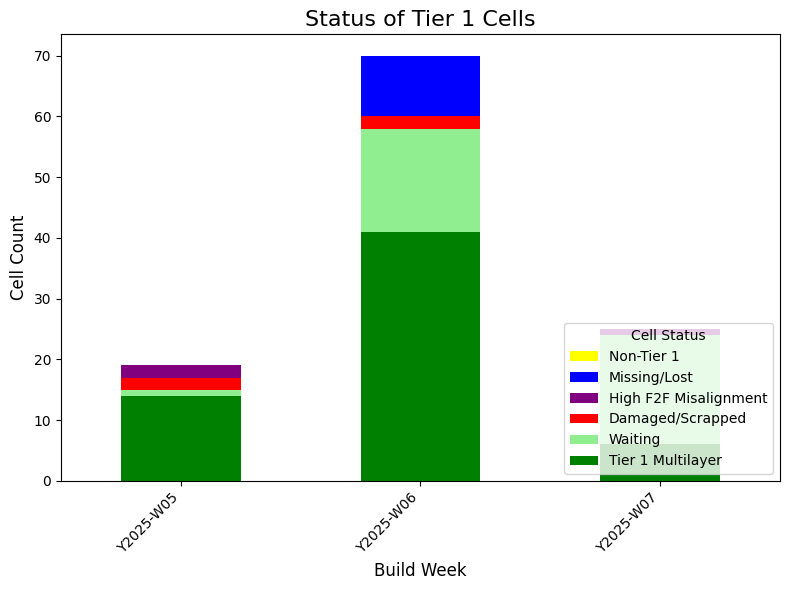

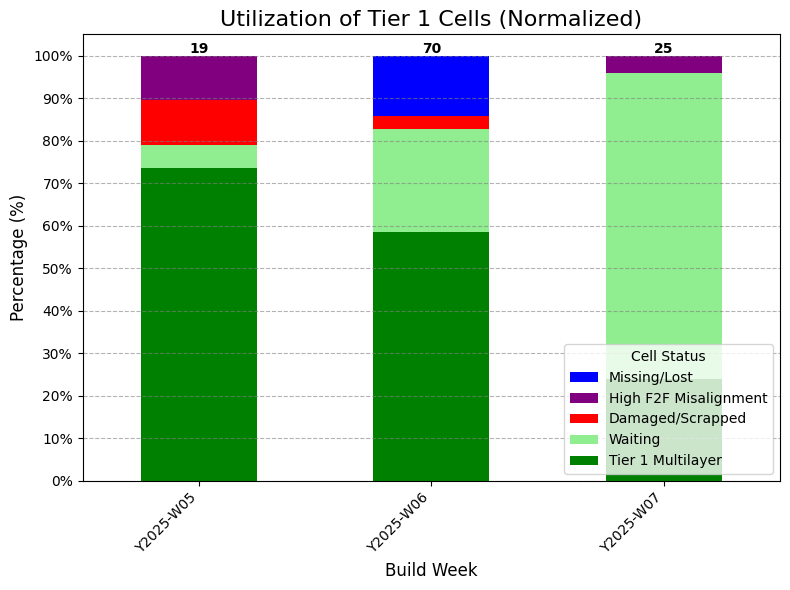

In [ ]:
# Filter out rows where 'Cell Status' is 'Non-Tier 1'
JustTier1Cells = CellsBuilt[CellsBuilt['Cell Status'] != 'Non-Tier 1']

# Now you can proceed with the grouped analysis or plotting
grouped = JustTier1Cells.groupby(['US_start_week', 'Cell Status']).size().unstack(fill_value=0)

# Define the desired order for 'Cell Status' (adjust based on your data)
desired_order = ['Tier 1 Multilayer', 'Waiting',  'Damaged/Scrapped', 'High F2F Misalignment','Missing/Lost']  # Example order
shade=['Green', 'lightgreen', 'Red', 'Purple', 'Blue', 'Yellow']
# Reorder the columns according to the desired order
grouped = grouped[desired_order]

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, figsize=(8, 6), color=shade)
# Add labels and title
plt.title('Status of Tier 1 Cells', fontsize=16)
plt.xlabel('Build Week', fontsize=12)
plt.ylabel('Cell Count', fontsize=12)
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Reverse the order of the legend
handles.reverse()
labels.reverse()
# Update the legend with the reversed order
plt.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 0.0), title="Cell Status")
# Display the plot
plt.tight_layout()
plt.show()


# Calculate the total cell count for each group (row)
totals = grouped.sum(axis=1)

# Normalize by dividing each value by the sum of the row (so it sums to 1 or 100%)
grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart (with normalized values as percentage)
ax = grouped_normalized.plot(kind='bar', stacked=True, figsize=(8, 6), color=shade)

# Add labels with total cell counts on top of each bar
for i, total in enumerate(totals):
    ax.text(i, 100, str(total), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add tick marks at every 10% on the y-axis
ax.set_yticks(range(0, 110, 10))  # Set tick marks from 0 to 100, in increments of 10
ax.set_yticklabels([f"{i}%" for i in range(0, 110, 10)])  # Add '%' to the tick labels
# Add grid lines at y-axis tick marks
ax.grid(axis='y', which='major', linestyle='--', color='gray', alpha=0.6)
# Add labels and title
plt.title('Utilization of Tier 1 Cells (Normalized)', fontsize=16)
plt.xlabel('Build Week', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Reverse the order of the legend
handles.reverse()
labels.reverse()
# Update the legend with the reversed order
plt.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 0.0), title="Cell Status")
# Display the plot
plt.tight_layout()
plt.show()

